In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 글씨체 설정 코드입니다.
# 이 코드는 실행시키고 하면 바로 잘 적용되는듯?
# 사용자 정의 함수 사용할때도 잘 적용됨
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)
fm._rebuild()

In [3]:
## 필요한 패캐지는 여기에 적어주세요.
import numpy as np
import pandas as pd
import requests 
import sys
import json
import datetime 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
from scipy.stats import probplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import time
import re

## 전처리

### 음식점 & 주점 수 전처리

In [4]:
general_food=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/음식점&주점/일반음식점_음식_final.csv',  encoding = 'utf-8')
general_drink=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/음식점&주점/일반음식점_주점_final.csv',  encoding = 'utf-8')
play=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/음식점&주점/유흥주점_final.csv', encoding = 'utf-8')
drink=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/음식점&주점/단란주점_final.csv',  encoding = 'utf-8')

general_drink_dong = general_drink.groupby(['행정동','구'])['관리번호'].count()
drink_dong = drink.groupby(['행정동','구'])['관리번호'].count()
play_dong = play.groupby(['행정동','구'])['관리번호'].count()

merge_1=pd.merge(general_drink_dong,drink_dong,on=["행정동","구"],how="outer")
drink_total=pd.merge(merge_1,play_dong,on=["행정동","구"],how="outer")
drink_total.fillna(0,inplace=True)
drink_total["주점 수"]=drink_total["관리번호_x"]+drink_total["관리번호_y"]+drink_total["관리번호"]
drink_total=drink_total.drop(["관리번호_x","관리번호_y","관리번호"],axis=1)
drink_total=drink_total.reset_index()

# 일반음식점 수:
food_total = general_food.groupby(['행정동','구'])['관리번호'].count()
food_total=food_total.reset_index()
food_total.rename(columns={'관리번호':'음식점 수'},inplace=True)

### 구별 쓰레기 배출량

In [5]:
trash = pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/쓰레기배출량/구 별 재활용쓰레기 배출량.csv', encoding = 'utf-8')
trash_total=trash[["시군구","합계"]]
trash_total.rename({"합계":"구별 쓰레기배출량"},inplace=True)

### 행정동별 인구

In [6]:
people = pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/2차 전처리/인구/인구데이터_버전2_1.csv', encoding = 'utf-8')
# 2021년 생활인구+거주인구만 추출
people_2021=people[["시군구","행정동","행정동코드","전체거주인구","생활인구"]]

### 행정동 별 주택 수

In [7]:
house = pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/쓰레기배출량/행정동별 주택 수.csv', encoding = 'utf-8')

house=house[~house["동"].isin(["합계","소계"])]# 기존 데이터가 엑셀 데이터를 전처리한 것이기 때문에, 해당 데이터에 들어있는 구별 합계와 소계를 제거
house=house[["자치구","동","합계"]] #구와 동, 합계만 사용

#2021년에 맞도록 행정동 데이터를 전처리
# 강일동 --> 강일동, 상일 2동
house["합계"]=house["합계"].str.replace(",","").astype(int)

num_gangil=int(house.loc[house["동"]=="강일동","합계"])*(2.26/(1.1+2.26))
num_sangil2=int(house.loc[house["동"]=="강일동","합계"])*(1.1/(1.1+2.26))

house.loc[house["동"]=="상일동","동"]="상일1동"

house.loc[house["동"]=="강일동","합계"]=num_gangil
house=house.append({"자치구":"강동구","동":"상일2동","합계":num_sangil2} , ignore_index=True)
house.rename(columns={"합계":"주택 수"},inplace=True)


###최종 데이터셋

In [8]:
# 데이터들 2021 버전으로 수정하기
# 주점 수 o, 음식점 수 o, 주택 수 o
# 항동 --> 없으면 채워주기
# 상일동 --> 상일 1동
# 강일동 --> 강일동, 상일 2동
house.rename(columns={'동':'행정동',"자치구":"시군구"},inplace=True)
drink_total.rename(columns={"구":"시군구"},inplace=True)
food_total.rename(columns={"구":"시군구"},inplace=True)

# 행정동 매칭 잘 안되면 행정동 띄어쓰기 모두 없애주기
people_2021["행정동"]=people_2021["행정동"].str.replace(" ","")
drink_total["행정동"]=drink_total["행정동"].str.replace(" ","")
food_total["행정동"]=food_total["행정동"].str.replace(" ","")
house["행정동"]=house["행정동"].str.replace(" ","")

# 관악구 신사동: 신사동_곽, 강남구 신사동_강
people_2021.loc[(people_2021["시군구"]=="관악구")&(people_2021["행정동"]=="신사동"),"행정동"]="신사동_관"
people_2021.loc[(people_2021["시군구"]=="강남구")&(people_2021["행정동"]=="신사동"),"행정동"]="신사동_강"
drink_total.loc[(drink_total["시군구"]=="관악구")&(drink_total["행정동"]=="신사동"),"행정동"]="신사동_관"
drink_total.loc[(drink_total["시군구"]=="강남구")&(drink_total["행정동"]=="신사동"),"행정동"]="신사동_강"
food_total.loc[(food_total["시군구"]=="관악구")&(food_total["행정동"]=="신사동"),"행정동"]="신사동_관"
food_total.loc[(food_total["시군구"]=="강남구")&(food_total["행정동"]=="신사동"),"행정동"]="신사동_강"
house.loc[(house["시군구"]=="관악구")&(house["행정동"]=="신사동"),"행정동"]="신사동_관"
house.loc[(house["시군구"]=="강남구")&(house["행정동"]=="신사동"),"행정동"]="신사동_강"

# 행정동별 인구 데이터로 merge

#people_2021, drink_total, food_total, house
merge_1=pd.merge(people_2021,drink_total,on=["행정동","시군구"],how="outer")
merge_2=pd.merge(merge_1,house,on=["행정동","시군구"],how="outer")
merge_3=pd.merge(merge_2,food_total,on=["행정동","시군구"],how="outer")

# trash: 구단위로 병합
dong_final = pd.merge(merge_3, trash_total, how='outer',on='시군구')
#결측치 0으로 대체
dong_final.fillna(0,inplace=True)
display(dong_final)


,시군구,행정동,행정동코드,전체거주인구,생활인구,주점 수,주택 수,음식점 수,합계
0,종로구,청운효자동,11110515,12177,16571.551560,6.0,4134.0,184.0,92175.3
1,종로구,사직동,11110530,9636,22968.574760,30.0,2778.0,707.0,92175.3
2,종로구,삼청동,11110540,2739,5550.662603,2.0,730.0,203.0,92175.3
3,종로구,부암동,11110550,9782,14839.390300,4.0,3070.0,106.0,92175.3
4,종로구,평창동,11110560,18329,18988.661760,5.0,5958.0,109.0,92175.3
...,...,...,...,...,...,...,...,...,...
421,강동구,성내2동,11740650,24106,25970.313260,67.0,6199.0,35.0,129754.4
422,강동구,성내3동,11740660,23346,26984.580650,76.0,6685.0,48.0,129754.4
423,강동구,길동,11740685,45973,52090.088740,176.0,14776.0,68.0,129754.4
424,강동구,둔촌1동,11740690,144,6282.221700,0.0,5.0,0.0,129754.4


In [9]:
# 상업지수 기준을 다르게하여 회귀분석 진행

# dong_train_1 상업지수: 생활인구/(생활인구+거주인구), 주점 수, 주택 수, 음식점 수
# dong_train_2: 거주인구, 생활인구, 주점 수, 주택 수, 음식점 수

dong_final["상업지수(인구)"]=dong_final["생활인구"]/(dong_final["생활인구"]+dong_final["전체거주인구"])
dong_train_1=dong_final[["시군구","행정동","상업지수(인구)","주점 수","주택 수","음식점 수","합계"]]
dong_train_2=dong_final[["시군구","행정동","전체거주인구","생활인구","주점 수","주택 수","음식점 수","합계"]]

## 회귀분석

왜 다른 모델들도 있는 회귀분석 모델을 진행하였냐면, xgbm같은 모델을 택하기에는 데이터 수가 굉장히 적어서 overfitting의 위험이 있기 때문이다. 물론 데이터 개수가 적을 때 decision tree와 knn같은 비모수적인 모델을 택하라는 것도 있었지만, decision tree와 KNN을 사용할 경우 새로운 데이터들도 결국은 강서구 쓰레기 배출량 범위 안에서만 예측되기 때문에 기존의 학습데이터의 결과값과 굉장히 차이가 큰 데이터를 예측해야 할때는 오차가 굉장히 커질 가능성이 크다.
그래서 우리는 전체적인 경향성을 볼 수 있는 회귀분석 모델을 택하기로 하였다.

### 학습데이터 전처리

In [10]:
data_total=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/regression/행정동 지역별 데이터.csv', encoding = 'utf-8')
data=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/regression/train.csv', encoding = 'utf-8')
data_people=pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/regression/train_people.csv', encoding = 'utf-8')

#강서구의 행정동별 쓰레기 배출량으로 학습을 진행할 예정이므로, 데이터에서 강서구 데이터만 추출해줌.
train=data.loc[data["시군구"]=="강서구"]
train_people=data_people.loc[data_people["시군구"]=="강서구"]
train_total=data_total.loc[data_total["시군구"]=="강서구"]

### 강서구 쓰레기 데이터 전처리

In [11]:
gangseo_data = pd.read_csv('/content/drive/Shareddrives/🐣DATAMINING_22_1🐣/주제분석/data/쓰레기배출량/강서구쓰레기배출량_2020.csv', encoding = 'utf-8')
gangseo_data=gangseo_data[~gangseo_data["행정동"].isin(["김포공항내","마곡지구","업체혼합"])]

gangseo_data['일반주택 2020']=gangseo_data['일반주택 2020'].str.replace(",","")
gangseo_data['공동주택 2020']=gangseo_data['공동주택 2020'].str.replace(",","")
gangseo_data['소형음식점 2020']=gangseo_data['소형음식점 2020'].str.replace(",","")
gangseo_data[["일반주택 2020","공동주택 2020","소형음식점 2020"]]=gangseo_data[["일반주택 2020","공동주택 2020","소형음식점 2020"]].apply(pd.to_numeric)

gangseo_data["쓰레기배출량2020"]=gangseo_data["일반주택 2020"]+gangseo_data["공동주택 2020"]

Y_train=gangseo_data[["행정동","쓰레기배출량2020"]]
# 마곡동은 법정동!!
Y_train=Y_train.loc[Y_train["행정동"]!="마곡동"].reset_index(drop=True)

final_train=pd.merge(Y_train,train_total, how='outer',on='행정동')

display(final_train)

,행정동,쓰레기배출량2020,시군구,행정동코드,전체거주인구,생활인구,주점 수,주택 수,음식점 수,합계,상업지수(인구)
0,가양1동,1348170,강서구,11500603,34395,46190.12075,112.0,7921.0,605.0,165988.1,0.573184
1,가양2동,602410,강서구,11500604,14109,15111.29898,12.0,7085.0,27.0,165988.1,0.517151
2,가양3동,186290,강서구,11500605,15138,10987.31657,8.0,7454.0,25.0,165988.1,0.420562
3,공항동,35890,강서구,11500620,31483,34380.34505,61.0,7888.0,186.0,165988.1,0.521995
4,등촌1동,28630,강서구,11500520,24436,22738.97968,42.0,6384.0,161.0,165988.1,0.482014
5,등촌2동,43240,강서구,11500530,20423,16283.31456,24.0,7009.0,54.0,165988.1,0.443611
6,등촌3동,104610,강서구,11500535,30714,38058.80010,45.0,13522.0,187.0,165988.1,0.553399
7,발산1동,2187100,강서구,11500611,36572,35460.66443,44.0,12284.0,215.0,165988.1,0.492286
8,방화1동,1315630,강서구,11500630,43181,33165.97601,84.0,13673.0,204.0,165988.1,0.434411
9,방화2동,1057180,강서구,11500640,23656,25139.92714,62.0,7532.0,198.0,165988.1,0.515205


### 시각화를 통한 데이터셋 확인

In [12]:
def visualizer(df,standard, target):
  '''
  히스토그램과 boxplot, barplot, 그리고 상관분석을 진행하는 함수
  df: 분석을 진행할 데이터셋(데이터프레임 형식)
  standard: barplot을 그릴때 기준(x축)에 들어갈 변수
  target: 시각화를 진행할 변수
  '''
  fig,ax=plt.subplots(len(target),2,figsize=(12,17))
  for i, col in enumerate(target):
    sns.distplot(df[col],ax=ax[i,0])
    sns.boxplot(x=col,data=df,ax=ax[i,1])

  f=lambda x: int(len(x)//2) if len(x)%2==0 else int(len(x)//2)+1
  fig,ax=plt.subplots(f(target),2,figsize=(12,24))
  for i, col in enumerate(target):
    sns.barplot(data=df,x=standard,y=col,ax=ax[i//2,i%2])

  plt.figure(figsize = (12,12))
  corr = df[target].corr(method='pearson')
  sns.heatmap(corr, annot=False, cmap=sns.light_palette("green", as_cmap=True))
  
  temp=df[target]
  vif = pd.DataFrame()
  vif["VIF Factor"] = [variance_inflation_factor(temp.values, i) for i in range(temp.shape[1])]
  vif["features"] = temp.columns

  display(corr)
  display(vif)


,상업지수(인구),주점 수,주택 수,음식점 수,전체거주인구,생활인구
상업지수(인구),1.000000,0.236912,-0.028988,0.564661,0.055531,0.515562
주점 수,0.236912,1.000000,0.393748,0.776316,0.548414,0.601509
주택 수,-0.028988,0.393748,1.000000,0.269731,0.882189,0.723882
음식점 수,0.564661,0.776316,0.269731,1.000000,0.527313,0.768268
전체거주인구,0.055531,0.548414,0.882189,0.527313,1.000000,0.871957
생활인구,0.515562,0.601509,0.723882,0.768268,0.871957,1.000000


,VIF Factor,features
0,10.570044,상업지수(인구)
1,11.032401,주점 수
2,67.363427,주택 수
3,25.889547,음식점 수
4,88.698261,전체거주인구
5,107.604201,생활인구


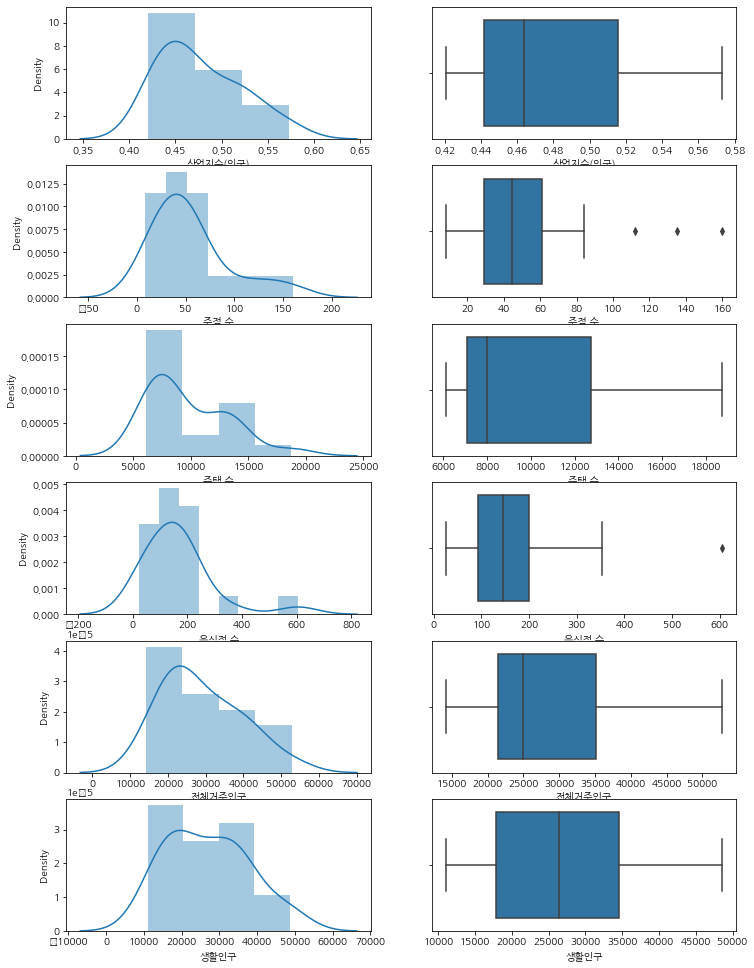

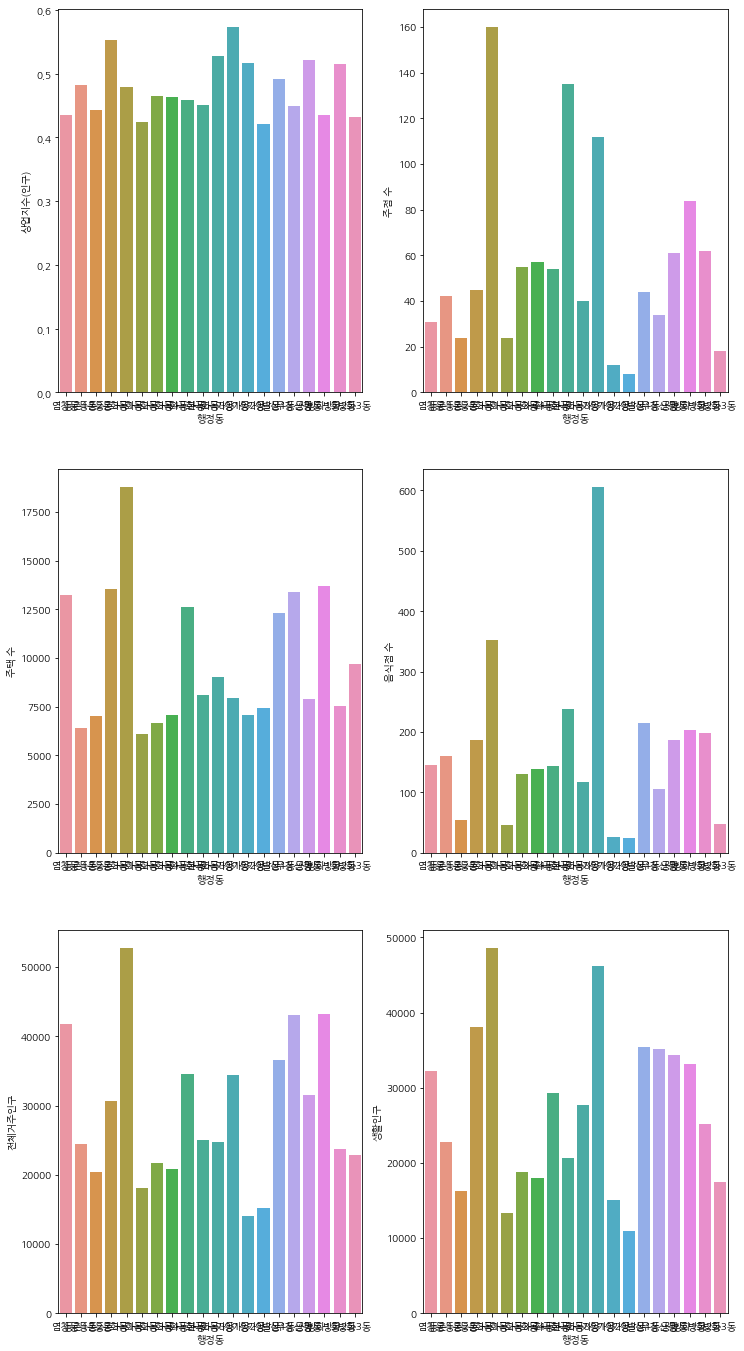

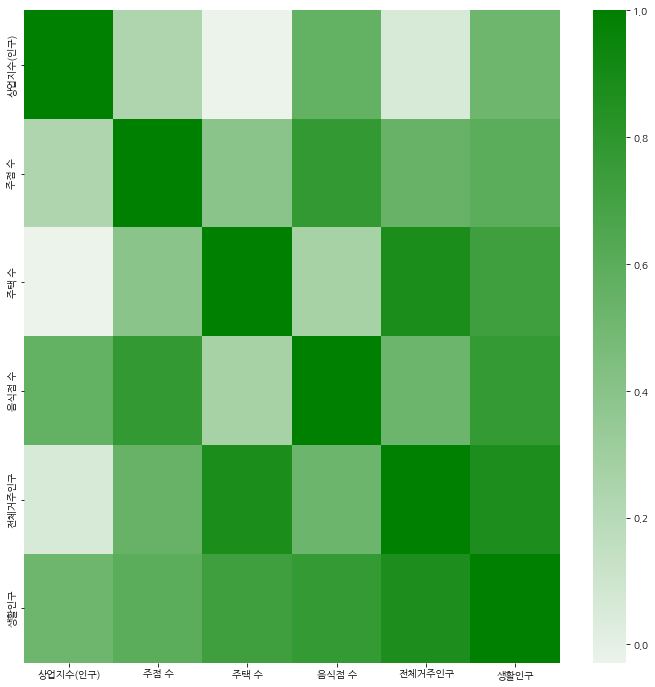

In [13]:
target_columns=["상업지수(인구)","주점 수","주택 수","음식점 수","전체거주인구","생활인구"]
standard_columns='행정동'
visualizer(train_total,standard_columns,target_columns)

진행의 편의를 위해 모든 변수들이 다 존재하는 데이터 셋으로 진행하였지만,
이 경우 VIF가 높게 나올 가능성이 존재하므로, 실제 분석에서는  

### 회귀분석툴

In [14]:
class regression_tool:
  def __init__(self,train,formula,standardize=None,test=None,log_transformation=False):
    self.train=train
    self.formula=formula
    self.standardize=standardize
    self.test=test
    self.var=re.split('[~+]',formula)
    self.log_transformation=log_transformation

  def variable_identifier(self,df):#설명변수와 반응변수 나눠주는 함수(class 안에서만 사용하기 위한 작품)
    df_response=df[self.var[0]]
    df_explanatory=df[self.var[1:]]

    return df_explanatory, df_response

  def scaler(self):
    train=self.train[self.var]
    try:
      test=self.test[self.var]
    except:
      test=None
    if self.standardize in ['standard', 'PCA']:
      scaler=StandardScaler()
      scaler.fit(train)
      train_scaled=pd.DataFrame(data=scaler.transform(train))
    elif self.standardize=='minmax':
      scaler=MinMaxScaler()
      scaler.fit(train)
      train_scaled=pd.DataFrame(data=scaler.transform(train))
    else:
      scaler=None
      train_scaled=train

    train_scaled.columns=self.var

    if test==None:
      return train_scaled
    else:
      try:
        test_scaled=pd.DataFrame(data=scaler.transform(test))
        test_scaled.columns=self.var
      except:
        test_scaled=test
      return train_scaled, test_scaled
    
  def log_transform(self, df):
    log_df=np.log(df)
    return log_df

  def regression_analysis(self):
    try:
      train, test=self.scaler()
    except:
      train = self.scaler()
    X_train, Y_train = self.variable_identifier(train)
    X_train=sm.add_constant(X_train,has_constant = "add")
    if self.log_transformation==True:
      Y_train=self.log_transform(Y_train)
    else:
      pass

    model = sm.OLS(Y_train, X_train)
    fitted_model = model.fit()
    display(fitted_model.summary())
    '''
    구현목록
    1. 회귀분석과 scaling
    2. 종속변수의 로그변환
    확인 결과 해당하는 부분에서는 잘 작동하는 것을 확인

    추가해야 될 항목
    1. PCA
    2. 회귀분석 진단(잔차plot, Normal Q-Q plot)
    3. 학습한 데이터 바탕으로 실제 예측 진행(Test data 활용)
    '''


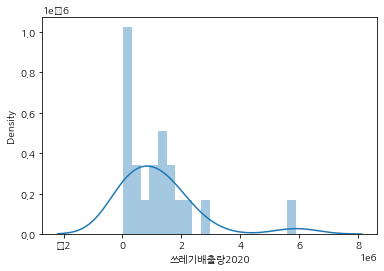

In [18]:
sns.distplot(final_train['쓰레기배출량2020'],bins=20)

모델 성능 업그레이드를 위한 제언
1. 주분때 모델 선택에서 Train Set으로 Fit 시킨 모델의 MSE나 R^2값만을 확인하였는데, K-fold CV를 사용해서 모델의 성능을 테스트한다면 좀 더 좋은 모델을 선택할 수 있을 것으로 보임.
2. Locally weighted regression 같은 비모수적인 방법을 채택하거나, 혹은 Regularization을 통해 overfitting 문제를 최대한 완화해보는 방법도 가능할 것으로 보임
3. 현재 히스토그램을보면 우리가 예측할 쓰레기 배출량이 모두 양수임을 알 수 있다. 회귀모델의 가정상 모든 X에서 Y는 X^t(theta)를 평균으로 하는 정규분포에 의해서 생성되었다고 볼 수도 있는데, 현재 히스토그램을 통해 확인해보면 정규분포보다는 right-tailed되어있는 감마분포를 따른다고 생각해볼 수 있을 것이다. 따라서, gamma regression을 시도해는 것도 괜찮아보임

In [15]:
result=regression_tool(final_train, '쓰레기배출량2020~주점 수+주택 수',log_transformation=True)
result.regression_analysis()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             쓰레기배출량2020   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     2.580
Date:                Sun, 03 Jul 2022   Prob (F-statistic):              0.105
Time:                        11:19:31   Log-Likelihood:                -34.425
No. Observations:                  20   AIC:                             74.85
Df Residuals:                      17   BIC:                             77.84
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6198      1.011     11.497      0.000       9.487      13.752
주점 수           0.0154      0.009      1.689      0.110      -0.004       0.035
주택 수        7.751e-05      0.000      0.732      0.474      -0.000       0.000
==============================================================================
Omnibus:                        2.684   Durbin-Watson:                   1.180
Prob(Omnibus):                  0.261   Jarque-Bera (JB):                2.204
Skew:                          -0.729   Prob(JB):                        0.332
Kurtosis:                       2.279   Cond. No.                     3.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
result2=regression_tool(final_train, '쓰레기배출량2020~주점 수+주택 수','standard')
result2.regression_analysis()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             쓰레기배출량2020   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     11.61
Date:                Sun, 03 Jul 2022   Prob (F-statistic):           0.000663
Time:                        11:19:31   Log-Likelihood:                -19.769
No. Observations:                  20   AIC:                             45.54
Df Residuals:                      17   BIC:                             48.53
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.388e-17      0.158   -8.8e-17      1.000      -0.333       0.333
주점 수           0.5104      0.172      2.975      0.008       0.148       0.872
주택 수           0.3967      0.172      2.312      0.034       0.035       0.759
==============================================================================
Omnibus:                        0.239   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.887   Jarque-Bera (JB):                0.396
Skew:                           0.198   Prob(JB):                        0.820
Kurtosis:                       2.436   Cond. No.                         1.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""